# Multidimensional Pattern identification with SAX
## In-site view

This script performs pattern identification over the {time, attribute} cuboid, that covers the intra-building frame. It serves for within-site exploration on how a given building operates across time and building-specific attributes.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Plotting modules
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
# Importing utility script
import utils as ut

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\insite_view\\"

## Read

In [2]:
# Read Cuboid
blg_id = "Bobcat_education_Alissa"
df = pd.read_csv(path_data + "cuboid_B_"+blg_id+".csv", index_col="timestamp")

# Format index to datetime object
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

# Reduce memory usage
df = ut.reduce_mem_usage(df, verbose=True)
df.head()

Mem. usage decreased to  0.33 Mb (64.3% reduction)


,electricity,gas,hotwater,chilledwater,airTemperature,seaLvlPressure
timestamp,,,,,,
2016-01-01 00:00:00,43.6875,3034.0,95.250,0.0,-14.398438,1037.0
2016-01-01 01:00:00,43.6875,3034.0,95.250,0.0,-13.296875,1036.0
2016-01-01 02:00:00,43.6875,3034.0,95.250,0.0,-15.000000,1036.0
2016-01-01 03:00:00,43.8750,3116.0,95.250,0.0,-12.796875,1035.0
2016-01-01 04:00:00,43.7500,3148.0,102.625,0.0,-14.398438,1035.0


# Pre-Mining
## Motifs identification

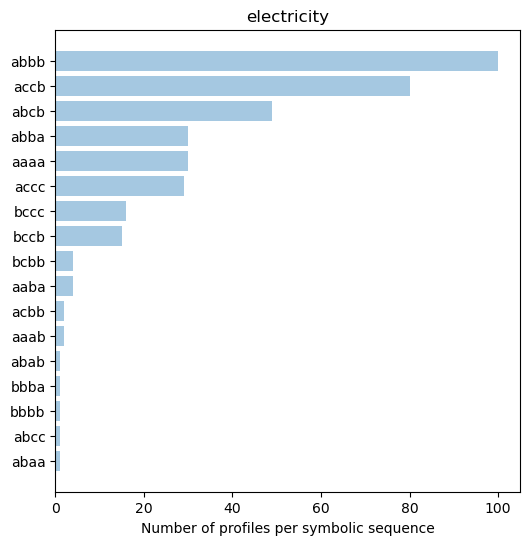

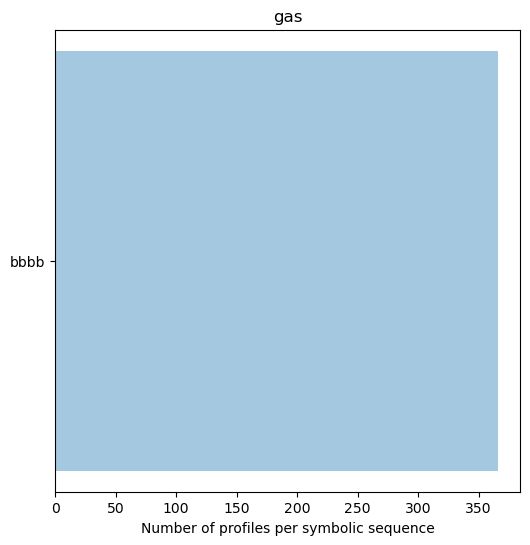

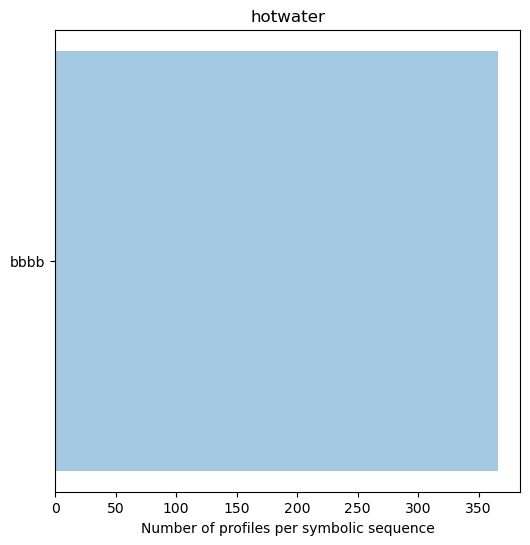

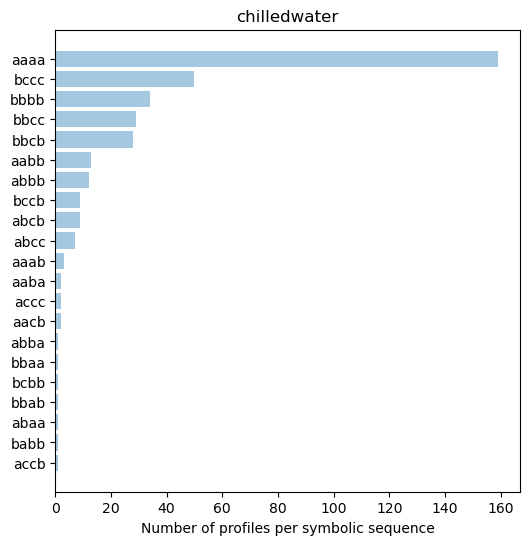

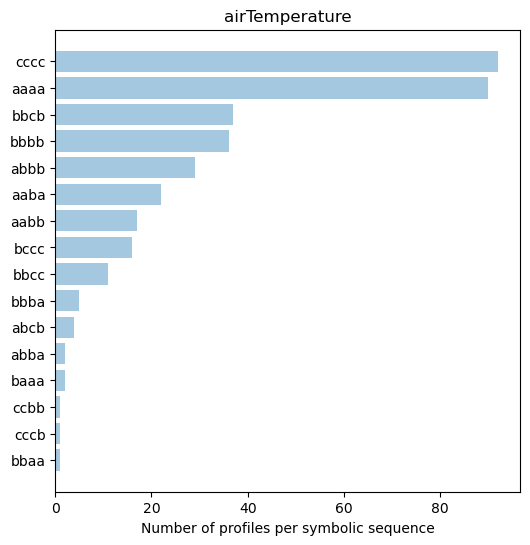

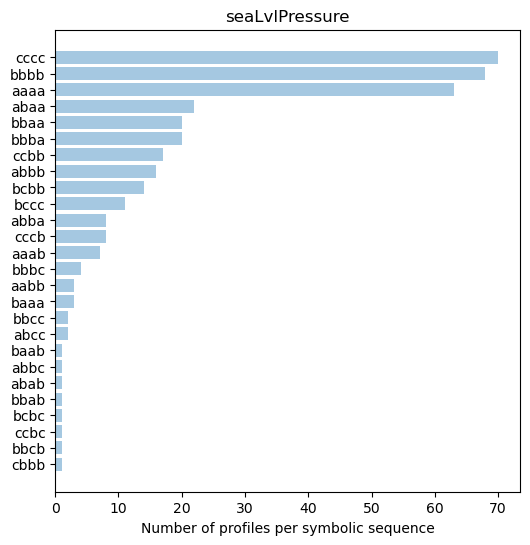

In [3]:
# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per attribute
df_normalized = ut.scale_df_columns_NanRobust(df, df.columns, scaler=scaler_function)

# Perform SAX transformation
sax_dict, counts, sax_data = ut.SAX_mining(df_normalized, W=day_number_of_pieces, A=alphabet_size)

# Plot the sequence counts per attribute
for meter in df.columns.values:
    fig = ut.counter_plot(counts[meter], title=meter)
    fig.savefig(path_fig_out+"SAXcounts_StandardScaler_blg_"+blg_id+"_meter_"+meter+"_"+version+".jpg", dpi=300, bbox_inches='tight')

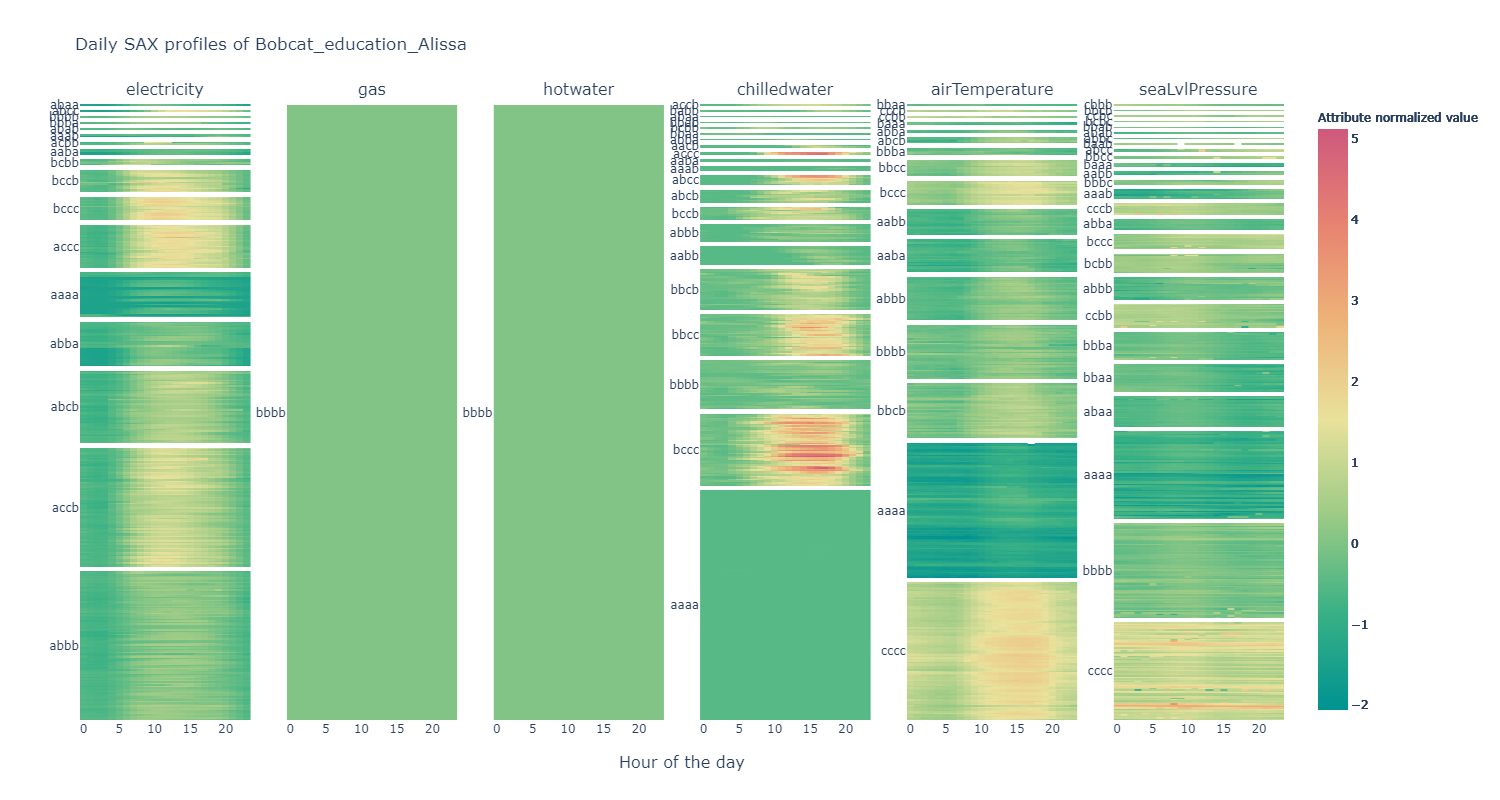

In [4]:
# Reformating sax results for plotting
sax_dict_data, index_map_dictionary = dict(), dict()
for meter in sax_data:
    sax_dict_data[meter], index_map_dictionary[meter] = ut.sax_df_reformat(sax_data, sax_dict, meter)

# Plotting all SAX sequences and saving figure
fig = ut.SAX_dailyhm_visualization(sax_dict_data, sax_dict, index_map_dictionary, title=blg_id)
ut.png_output([len(sax_dict.keys())*250, 800])
fig.show()
fig.write_image(path_fig_out+"SAX_blg_"+blg_id+"_"+version+".png")

In [5]:
# Filter discords from established threshold
threshold = 10  # motif number threshold
indexes = dict()
for meter in df.columns.values:
    df_count = pd.DataFrame.from_dict(Counter(sax_dict[meter]), orient='index').rename(columns={0:'count'})
    df_count.fillna(0)
    motifs = df_count[(df_count > threshold)]
    indexes[meter] = [i for i,x in enumerate(sax_dict[meter]) if x in list(motifs.index)]  # returns all indexes

# Mining
## Attribute motifs clustering
Attribute daily profile motifs are clustered together resulting in a reduced number of typical patterns from the previous motif identification thanks to SAX trasnformation.

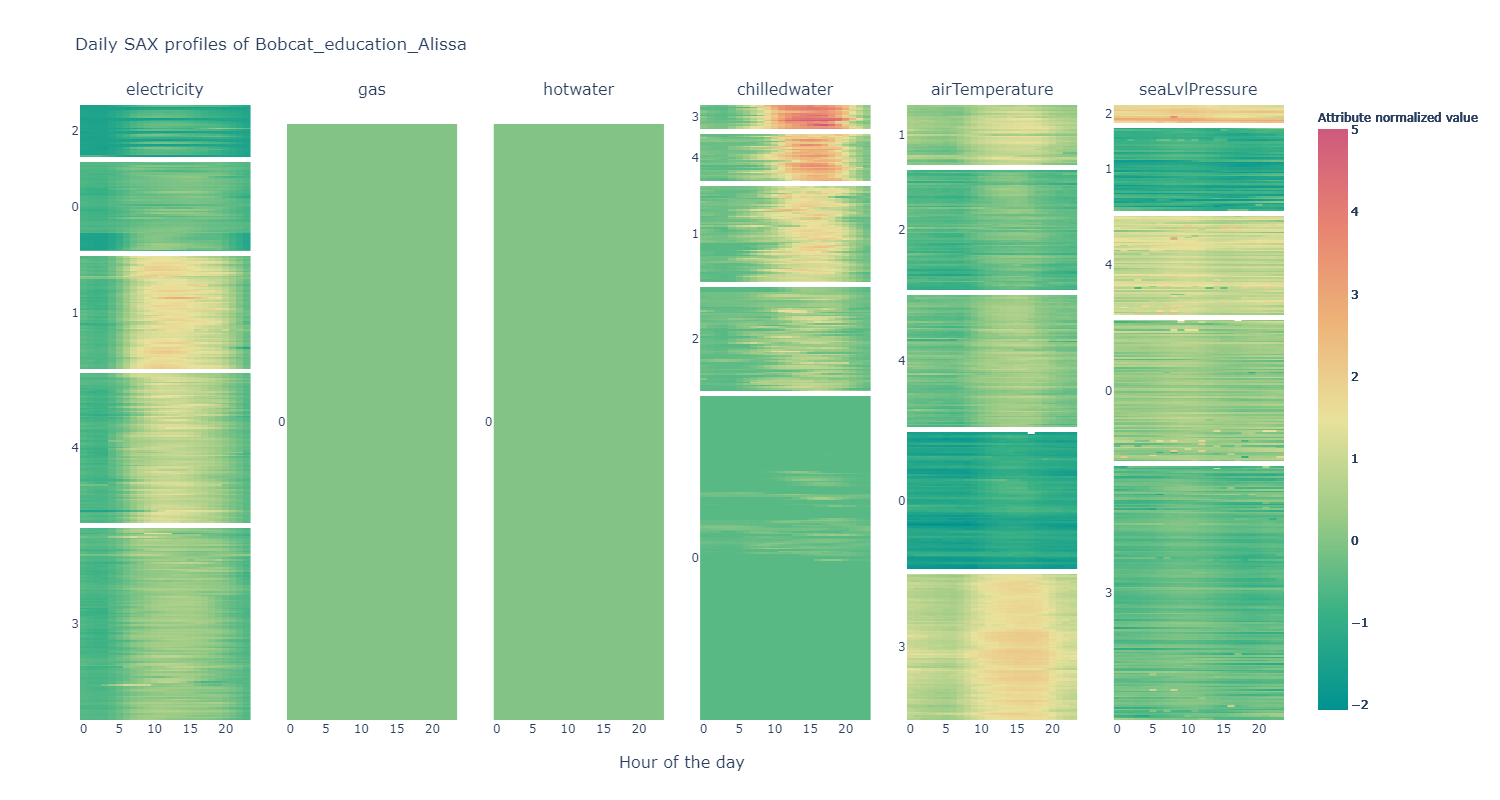

In [6]:
## Clustering identified motifs

# Cluster the identified motifs
nb_clusters_opt = 5
kmeans = KMeans(n_clusters=nb_clusters_opt, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pred_y, clust_sax_data = dict(), dict()
for meter in df.columns.values:
    clust_sax_data[meter] = sax_data[meter].iloc[indexes[meter]]
    kmeans_pred_y[meter] = kmeans.fit_predict(clust_sax_data[meter].interpolate(method='linear'))

# Reformating cluster results for plotting
clust_dict_data, index_map_dictionary = dict(), dict()
max_shape = 0
for meter in sax_data:
    clust_dict_data[meter], index_map_dictionary[meter] = ut.sax_df_reformat(clust_sax_data, kmeans_pred_y, meter)
    max_shape = max(max_shape, max(np.shape(clust_dict_data[meter])))
# Adjusting reformaating from variable attribute motifs lengths
for meter in sax_data:
    # Defining width of empty dataframe to add
    space_btw_saxseq = max_shape - max(np.shape(clust_dict_data[meter]))
    # Creating empty frame
    empty_sax_df = pd.DataFrame(columns=sax_data[meter].columns, index=[' ']*space_btw_saxseq)
    # Adding empty frame to the df
    clust_dict_data[meter] = clust_dict_data[meter].append(empty_sax_df)

# Plotting cluster results results
fig = ut.SAX_dailyhm_visualization(clust_dict_data, sax_dict, index_map_dictionary, title=blg_id)
ut.png_output([len(clust_dict_data.keys())*250, 800])
fig.show()
fig.write_image(path_fig_out+"clust_blg_"+blg_id+"_"+version+".png")